# Classification through Linear Regression/Logistic Regression using Gradient Descent

This notebook illustrates how to use linear regression and logistic regression AI algorithms to perform binary classification of digit images using different versions of gradient descent optimizers.


In [96]:
import numpy as np
import math
import matplotlib.pyplot as plt
import sklearn.datasets as dt
from sklearn.model_selection import train_test_split
import pandas as pd
%matplotlib inline

# Dataset
To illustrate gradient descent on a classification problem, we have chosen the "digits" dataset included in `sklearn.datasets`. 

## Plotting data

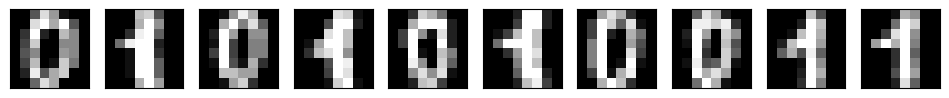

In [97]:
digits, target = dt.load_digits(n_class = 2,return_X_y= True)
fig, ax = plt.subplots(nrows=1, ncols=10,figsize=(12,4),subplot_kw=dict(xticks=[], yticks=[]))

# Plot some images of digits
for i in np.arange(10):
    ax[i].imshow(digits[i,:].reshape(8,8),cmap=plt.cm.gray)   
plt.show()


## Prepare Data

In [98]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(digits, target, test_size=0.2, random_state=42)

print(y_train[:10])
y_train = np.sign(y_train - 0.5)
print(y_train[:10])
y_test = np.sign(y_test - 0.5)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

[0 0 0 0 0 1 0 1 0 0]
[-1. -1. -1. -1. -1.  1. -1.  1. -1. -1.]
(288, 64)
(288,)
(72, 64)
(72,)


# Problem 1

In [99]:
## a. Linear Regression with Gradient Descent

class LinearRegressionGradientDescent():
    """
    Logistic regression implementation (gradient descent)
    """

    def __init__(self, d, w = None):
        # set the dimension of the input data
        self.d = d
        # initialize the weights if necessary
        if w is None:
            self.w = np.random.rand((d + 1))
        else:
            assert len(w) == (d+1), f'Weight vector has length {len(w)}, but dimension was set to {d} + 1'
            self.w = w

    def MSE(self, X, y):
        # get the number of data points
        N = X.shape[0]
        return (1/(2*N)) * (np.sum((self.h(X) - y)**2))
    
    def MSE_gradient(self, X, y):
        # get the number of data points
        N = X.shape[0]
        h = self.h(X)

        # prepend a column of ones, 
        # we do not do it before computing h, since we do that in h() as well
        ones = np.ones((X.shape[0], 1))
        X = np.concatenate((ones, X), axis=1)
        # compute the gradient
        delta = (1/N) * ((h - y).T.dot(X)) * 2 

        return delta

    def fit(self, X, y, eta=0.01, epochs=5):
        """
        Parameters
        ----------
        X : Array of shape [n_samples, n_features]
        y : Array of shape [n_samples, 1]
        """

        deltas = []
        errros = []
        accuracies = []

        # gradient descent steps
        for epoch in range(epochs):
            # get the gradient
            delta = self.MSE_gradient(X, y)

            self.w = self.w - (eta * delta.T)

            deltas.append(float(np.mean(delta)))
            errros.append(self.MSE(X, y))
            accuracies.append(self.accuracy(X, y))

        return errros, deltas, accuracies

        
    # prediction
    def h(self, X):
        # prepend a column of ones
        ones = np.ones((X.shape[0], 1))
        X = np.concatenate((ones, X), axis=1)
        y_hat = np.sign(X @ self.w)
        return y_hat
    
    
    def accuracy(self, X, y):
        y_hat = self.h(X)
        percentage = np.mean(y_hat == y)
        return percentage




In [100]:
lr = LinearRegressionGradientDescent(X_train.shape[1])
errros, deltas, accuracies = lr.fit(X_train, y_train, eta=0.001, epochs=5)

test_accuracy = lr.accuracy(X_test, y_test)
print(f'Final test accuracy: {test_accuracy}')

Final test accuracy: 0.5138888888888888


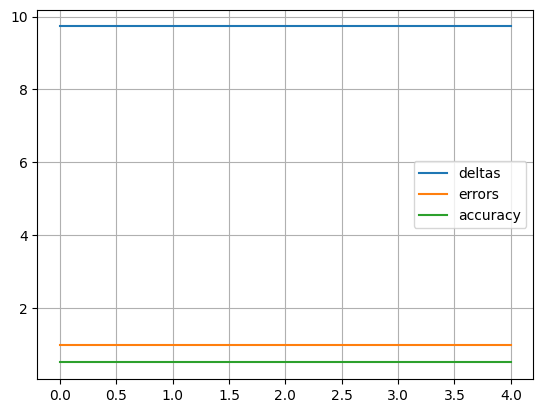

In [101]:
plt.plot(deltas)
plt.plot(errros)
plt.plot(accuracies)

plt.grid(True)

plt.legend([
    "deltas",
    "errors",
    "accuracy"
])

## Linear Regression with mini-batch Gradient Descent

In [102]:
class LinearRegressionGradientDescentMiniBatch():
    """
    Logistic regression implementation (gradient descent)
    """

    def __init__(self, d, w = None):
        # set the dimension of the input data
        self.d = d
        # initialize the weights if necessary
        if w is None:
            self.w = np.random.rand((d + 1))
        else:
            self.w = w

    def MSE(self, X, y):
        # get the number of data points
        N = X.shape[0]
        return (1/(2*N)) * (np.sum((self.h(X) - y)**2))
    
    def MSE_gradient(self, X, y):
        # get the number of data points
        N = X.shape[0]
        h = self.h(X)

        # prepend a column of ones, 
        # we do not do it before computing h, since we do that in h() as well
        ones = np.ones((X.shape[0], 1))
        X = np.concatenate((ones, X), axis=1)
        # compute the gradient
        delta = (1/N) * ((h - y).T.dot(X))

        return delta

    def fit(self, X, y, eta=0.01, epochs=5, batch_size = 4):
        """
        Parameters
        ----------
        X : Array of shape [n_samples, n_features]
        y : Array of shape [n_samples, 1]
        """

        deltas = []
        errros = []
        accuracies = []

        # gradient descent steps
        for epoch in range(epochs):
            # get the gradient
            mini_batches = self.create_mini_batches(X, y, batch_size)

            mini_deltas = []

            for mini_batch in mini_batches:
                X_mini, y_mini = mini_batch

                delta = self.MSE_gradient(X_mini, y_mini)
                mini_deltas.append(float(np.mean(delta)))

                self.w = self.w - (eta * delta.T)

            deltas.append(float(np.mean(mini_deltas)))
            errros.append(self.MSE(X, y))
            accuracies.append(self.accuracy(X, y))

        return errros, deltas, accuracies

    def create_mini_batches(self, X, y, batch_size):
        mini_batches = []

        # create a random permutation of the data
        permutation =  np.random.permutation(X.shape[0])
        X_perm = X[permutation]
        y_perm = y[permutation]

        n_minibatches = X.shape[0] // batch_size
        # make sure that we get the last training instances if the data set
        # is not evenly divisible by the batch size
        if X.shape[0] % batch_size != 0:
            n_minibatches += 1


        for i in range(n_minibatches):
            lower = i * batch_size
            lower = min(lower, X.shape[0])
            upper = i * batch_size + batch_size
            upper = min(upper, X.shape[0])

            X_mini = X_perm[lower:upper, ]
            y_mini = y_perm[lower:upper]

            mini_batches.append((X_mini, y_mini))

        return mini_batches


    def accuracy(self, X, y):
        y_hat = self.h(X)
        percentage = np.mean(y_hat == y)
        return percentage

        
    # prediction
    def h(self, X):
        # prepend a column of ones
        ones = np.ones((X.shape[0], 1))
        X = np.concatenate((ones, X), axis=1)
        y_hat = np.sign(X @ self.w)
        return y_hat


In [103]:
lr = LinearRegressionGradientDescentMiniBatch(X_train.shape[1])
errros, deltas, accuracies = lr.fit(X_train, y_train, eta=0.001, epochs=1, batch_size=1)

test_accuracy = lr.accuracy(X_test, y_test)
print(f'Final test accuracy: {test_accuracy}')

Final test accuracy: 1.0


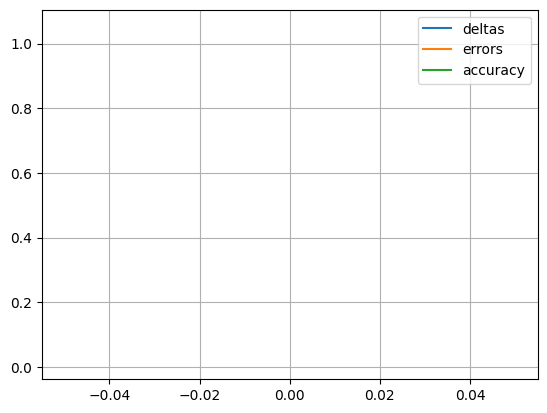

In [106]:
ax = plt.axes()
ax.plot(deltas)
ax.plot(errros)
ax.plot(accuracies)

ax.grid(True)

ax.legend([
    "deltas",
    "errors",
    "accuracy"
])

## Linear Regression with mini-batch Gradient Descent and Momentum

In [107]:
class LinearRegressionGradientDescentMiniBatchMomentum():
    """
    Logistic regression implementation (gradient descent)
    """

    def __init__(self, d, w = None):
        # set the dimension of the input data
        self.d = d
        # initialize the weights if necessary
        if w is None:
            self.w = np.random.rand((d + 1))
        else:
            self.w = w

    def MSE(self, X, y):
        # get the number of data points
        N = X.shape[0]
        return (1/(2*N)) * (np.sum((self.h(X) - y)**2))
    
    def MSE_gradient(self, X, y):
        # get the number of data points
        N = X.shape[0]
        h = self.h(X)

        # prepend a column of ones, 
        # we do not do it before computing h, since we do that in h() as well
        ones = np.ones((X.shape[0], 1))
        X = np.concatenate((ones, X), axis=1)
        # compute the gradient
        delta = (1/N) * ((h - y).T.dot(X))

        return delta

    def fit(self, X, y, eta=0.01, epochs=5, batch_size = 4, kappa = 0.9):
        """
        Parameters
        ----------
        X : Array of shape [n_samples, n_features]
        y : Array of shape [n_samples, 1]
        """

        deltas = []
        errros = []
        accuracies = []

        # gradient descent steps
        for epoch in range(epochs):
            mini_batches = self.create_mini_batches(X, y, batch_size)

            old_update = np.zeros(self.w.shape[0])

            mini_deltas = []

            for mini_batch in mini_batches:
                X_mini, y_mini = mini_batch

                gradient = self.MSE_gradient(X_mini, y_mini)
                update = eta * gradient.T
                self.w = self.w - update - kappa * old_update

                mini_deltas.append(float(np.mean(update - kappa * old_update)))

                old_update = update

            deltas.append(float(np.mean(mini_deltas)))
            errros.append(self.MSE(X, y))
            accuracies.append(self.accuracy(X, y))

        return errros, deltas, accuracies

    def create_mini_batches(self, X, y, batch_size):
        mini_batches = []

        # create a random permutation of the data
        permutation =  np.random.permutation(X.shape[0])
        X_perm = X[permutation]
        y_perm = y[permutation]


        n_minibatches = X.shape[0] // batch_size
        # make sure that we get the last training instances if the data set
        # is not evenly divisible by the batch size
        if X.shape[0] % batch_size != 0:
            n_minibatches += 1


        for i in range(n_minibatches):
            lower = i * batch_size
            lower = min(lower, X.shape[0])
            upper = i * batch_size + batch_size
            upper = min(upper, X.shape[0])

            X_mini = X_perm[lower:upper, ]
            y_mini = y_perm[lower:upper]

            mini_batches.append((X_mini, y_mini))

        return mini_batches
    
    def accuracy(self, X, y):
        y_hat = self.h(X)
        percentage = np.mean(y_hat == y)
        return percentage

    # prediction
    def h(self, X):
        # prepend a column of ones
        ones = np.ones((X.shape[0], 1))
        X = np.concatenate((ones, X), axis=1)
        y_hat = np.sign(X @ self.w)
        return y_hat


In [108]:
lr = LinearRegressionGradientDescentMiniBatchMomentum(X_train.shape[1])
errros, deltas, accuracies = lr.fit(X_train, y_train, eta=0.01, epochs=1, batch_size=4, kappa=0.1)

test_accuracy = lr.accuracy(X_test, y_test)
print(f'Final test accuracy: {test_accuracy}')

Final test accuracy: 1.0


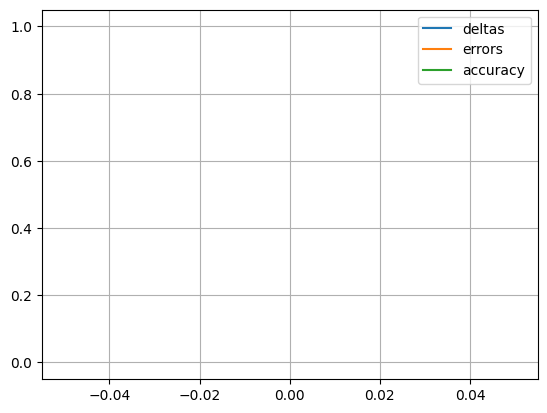

In [109]:
plt.plot(deltas)
plt.plot(errros)
plt.plot(accuracies)

plt.grid(True)

plt.legend([
    "deltas",
    "errors",
    "accuracy"
])

## Find optimal hyper-parameters

In [110]:
etas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
epochs = [1, 3, 5, 10, 25]
batch_sizes = [1, 2, 4, 8, 16, X_train.shape[0]]
kappas = [0, 0.0001, 0.001, 0.01, 0.1, 0.5]

total_combinations = len(etas) * len(epochs) * len(batch_sizes) * len(kappas)

optimal_models = []
optimal_parameters = []
for eta in etas:
    for epoch in epochs:
        for batch_size in batch_sizes:
            for kappa in kappas:
                np.random.seed(42)
                lr = LinearRegressionGradientDescentMiniBatchMomentum(X_train.shape[1])
                errros, deltas, accuracies = lr.fit(X_train, y_train, eta=eta, epochs=epoch, batch_size=batch_size, kappa=kappa)

                test_accuracy = lr.accuracy(X_test, y_test)

                if test_accuracy == 1:
                    optimal_models.append({"model": lr,
                                            "errors": errros,
                                            "deltas": deltas,
                                            "accuracies": accuracies,
                                            "eta": eta,
                                            "epochs": epoch,
                                            "batch_size": batch_size,
                                            "test_accuracy": test_accuracy})
                    
                    optimal_parameters.append({"eta": eta,
                                                "epochs": epoch,
                                                "batch_size": batch_size,
                                                "kappa": kappa})


In [111]:
print(f'{len(optimal_models)} optimal parameter combinations out of {total_combinations}.')

optimal_model = optimal_models[7]

for parameter in optimal_model:
    print(f'{parameter}: {optimal_model[parameter]}')
len(optimal_model)

535 optimal parameter combinations out of 1080.
model: <__main__.LinearRegressionGradientDescentMiniBatchMomentum object at 0x00000282EAB3F520>
errors: [0.06944444444444445, 0.013888888888888888, 0.013888888888888888]
deltas: [0.0009784277884615387, -3.333e-05, 3.952596153846158e-06]
accuracies: [0.9652777777777778, 0.9930555555555556, 0.9930555555555556]
eta: 0.001
epochs: 3
batch_size: 1
test_accuracy: 1.0


8

,eta,epochs,batch_size,kappa
0,0.0001,25,1,0.0000
1,0.0001,25,1,0.0001
2,0.0001,25,1,0.0010
3,0.0001,25,1,0.0100
4,0.0001,25,1,0.1000


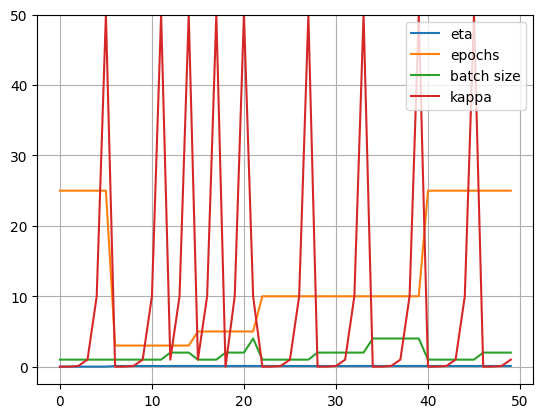

In [112]:
import pandas as pd

df = pd.DataFrame(optimal_parameters[:50])
display(df.head())
df["eta"] = df["eta"] * 100
df["kappa"] = df["kappa"] * 100

plt.plot(df)
plt.ylim(top=50)
plt.grid(True)

plt.legend([
    "eta",
    "epochs",
    "batch size",
    "kappa"
])

# Logistis Regression

In [120]:
class LogisticRegression():
    """
    Logistic regression implementation (gradient descent)
    """

    def __init__(self, d, w = None):
        # set the dimension of the input data
        self.d = d
        # initialize the weights if necessary
        if w is None:
            self.w = np.random.rand((d + 1))
        else:
            self.w = w


    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    
    def CE(self, X, y):
        N = X.shape[0]
        ones = np.ones((X.shape[0], 1))
        X = np.concatenate((ones, X), axis=1)
        return (1/N) * np.sum(np.log(1 + np.exp(-np.multiply(y, X @ self.w))))
    
    
    def CE_gradient(self, X, y):
        ones = np.ones((X.shape[0], 1))
        X = np.concatenate((ones, X), axis=1)

        N = X.shape[0]

        gradient_E = np.zeros(self.w.shape)

        for i in range(N):
            gradient_E += y[i] * X[i, :] / (1 + np.exp(y[i] * self.w.dot(X[i, :])))
        gradient_E /= N
        gradient_E *= -1

        return gradient_E

    def fit(self, X, y, eta=0.01, epochs=5, batch_size = 4):
        """
        Parameters
        ----------
        X : Array of shape [n_samples, n_features]
        y : Array of shape [n_samples, 1]
        """

        deltas = []
        errros = []
        accuracies = []

        # gradient descent steps
        for epoch in range(epochs):
            # get the gradient
            mini_batches = self.create_mini_batches(X, y, batch_size)

            mini_deltas = []

            for mini_batch in mini_batches:
                X_mini, y_mini = mini_batch

                delta = self.CE_gradient(X_mini, y_mini)

                self.w = self.w - eta * delta.T

                mini_deltas.append(float(np.mean(delta)))

            deltas.append(float(np.mean(mini_deltas)))
            errros.append(self.CE(X, y))
            accuracies.append(self.accuracy(X, y))

        return errros, deltas, accuracies


    def create_mini_batches(self, X, y, batch_size):
        mini_batches = []

        # create a random permutation of the data
        permutation =  np.random.permutation(X.shape[0])
        X_perm = X[permutation]
        y_perm = y[permutation]


        n_minibatches = X.shape[0] // batch_size
        # make sure that we get the last training instances if the data set
        # is not evenly divisible by the batch size
        if X.shape[0] % batch_size != 0:
            n_minibatches += 1


        for i in range(n_minibatches):
            lower = i * batch_size
            lower = min(lower, X.shape[0])
            upper = i * batch_size + batch_size
            upper = min(upper, X.shape[0])

            X_mini = X_perm[lower:upper, ]
            y_mini = y_perm[lower:upper]

            mini_batches.append((X_mini, y_mini))

        return mini_batches
    
    def accuracy(self, X, y):
        y_hat = self.h(X)
        y_hat = np.where(y_hat >= 0.5, 1, -1)
        percentage = np.mean(y_hat == y)
        return percentage
    
    def h(self, X):
        # prepend a column of ones
        ones = np.ones((X.shape[0], 1))
        X = np.concatenate((ones, X), axis=1)
        y_hat = self.sigmoid(X @ self.w)
        return y_hat
    

In [121]:
lr = LogisticRegression(X_train.shape[1])
errros, deltas, accuracies = lr.fit(X_train, y_train, eta=0.01, epochs=1, batch_size=4)

test_accuracy = lr.accuracy(X_test, y_test)
print(f'Final test accuracy: {test_accuracy}')
errros[-1]

[-1 -1 -1 -1 -1  1 -1  1 -1 -1  1  1  1  1 -1  1  1 -1  1 -1 -1 -1  1  1
 -1 -1  1 -1 -1 -1  1 -1 -1  1  1 -1  1  1 -1  1  1  1  1 -1  1  1 -1  1
  1  1 -1 -1  1  1  1  1  1 -1 -1 -1 -1 -1  1 -1  1 -1  1  1  1  1 -1 -1
 -1  1 -1  1  1  1 -1  1 -1 -1 -1 -1  1  1 -1 -1 -1 -1 -1  1 -1  1  1  1
  1  1 -1  1  1 -1 -1  1 -1 -1 -1  1 -1  1 -1 -1  1  1  1 -1  1  1  1  1
  1  1 -1 -1 -1  1 -1  1 -1  1  1  1 -1  1  1  1  1 -1  1 -1  1  1  1 -1
  1 -1  1 -1 -1  1  1  1 -1  1 -1  1 -1  1 -1  1  1  1 -1 -1 -1  1  1  1
  1 -1 -1 -1  1 -1 -1  1 -1 -1 -1 -1 -1  1  1  1  1  1  1  1 -1  1  1  1
  1 -1  1 -1  1 -1 -1  1 -1 -1  1 -1  1  1  1 -1  1 -1  1 -1  1  1  1 -1
  1 -1 -1  1  1 -1  1 -1  1  1  1 -1  1 -1  1  1  1 -1 -1 -1  1 -1  1 -1
 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1  1 -1 -1  1 -1  1 -1  1
  1 -1 -1  1 -1 -1  1 -1  1 -1  1  1  1  1  1 -1 -1  1 -1  1 -1  1  1  1]
[ 1 -1 -1  1 -1 -1 -1  1 -1  1 -1  1  1  1 -1  1  1 -1  1  1 -1  1 -1 -1
  1 -1 -1  1 -1  1 -1  1  1  1  1  1  1 -1 -1 -1  

0.11221675011481369

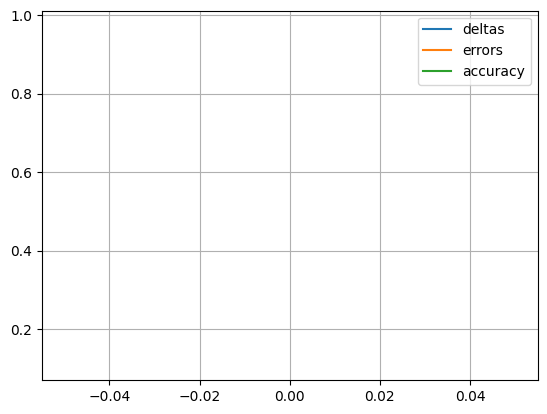

In [122]:
plt.plot(deltas)
plt.plot(errros)
plt.plot(accuracies)

plt.grid(True)

plt.legend([
    "deltas",
    "errors",
    "accuracy"
])

## Find optimal hyper-parameters

In [60]:
etas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
epochs = [1, 3, 5, 10, 25]
batch_sizes = [1, 2, 4, 8, 16, X_train.shape[0]]

total_combinations = len(etas) * len(epochs) * len(batch_sizes)

optimal_models = []
optimal_parameters = []
for eta in etas:
    for epoch in epochs:
        for batch_size in batch_sizes:
                np.random.seed(42)
                lr = LogisticRegression(X_train.shape[1])
                errros, deltas, accuracies = lr.fit(X_train, y_train, eta=eta, epochs=epoch, batch_size=batch_size)

                test_accuracy = lr.accuracy(X_test, y_test)

                if test_accuracy > 0.99:
                    optimal_models.append({"model": lr,
                                            "errors": errros,
                                            "deltas": deltas,
                                            "accuracies": accuracies,
                                            "eta": eta,
                                            "epochs": epoch,
                                            "batch_size": batch_size,
                                            "test_accuracy": test_accuracy})
                    
                    optimal_parameters.append({"eta": eta,
                                                "epochs": epoch,
                                                "batch_size": batch_size})


/var/folders/dl/ql567y8n0gnbkgyw5xljmmkw0000gn/T/ipykernel_4963/1072708438.py:36: RuntimeWarning: overflow encountered in exp
  gradient_E += y[i] * X[i, :] / (1 + np.exp(y[i] * self.w.dot(X[i, :])))
/var/folders/dl/ql567y8n0gnbkgyw5xljmmkw0000gn/T/ipykernel_4963/1072708438.py:17: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
/var/folders/dl/ql567y8n0gnbkgyw5xljmmkw0000gn/T/ipykernel_4963/1072708438.py:24: RuntimeWarning: overflow encountered in exp
  return (1/N) * np.sum(np.log(1 + np.exp(-np.multiply(y, X @ self.w))))


In [61]:
print(f'{len(optimal_models)} optimal parameter combinations out of {total_combinations}.')

optimal_model = optimal_models[3]

for parameter in optimal_model:
    print(f'{parameter}: {optimal_model[parameter]}')

79 optimal parameter combinations out of 180.
model: <__main__.LogisticRegression object at 0x294514c70>
errors: [0.20908554997384146, 0.074707882407863, 0.04618963176342163, 0.03419868624171547, 0.02696773171215769, 0.02298200142985804, 0.014803468239654217, 0.010901148587154377, 0.007569278398879734, 0.006523054754905256, 0.004778477337238985, 0.0038805886393877935, 0.0031243991586599063, 0.0028154821701654596, 0.0023985358008336973, 0.002244850530973768, 0.001973331577805829, 0.0018380172767798898, 0.001670252581829436, 0.0015645936820873427, 0.0014679787684988056, 0.001386222331798271, 0.0012932352052133893, 0.0012251492197803994, 0.0011634331655825533]
deltas: [0.9510237698480855, -0.007200177913945116, 0.00026204534400362585, -0.002669387541837356, 0.011647831855884673, 0.0010344110517137542, -0.00963465184043879, -0.0055867690040836936, 0.001624664365949696, 0.005408407228698554, -0.008567832087863443, 0.0010390572535465702, 0.0013239263245516655, 0.004170232778258388, -0.002801

,eta,epochs,batch_size
0,0.001,5,1
1,0.001,10,1
2,0.001,10,2
3,0.001,25,1
4,0.001,25,2


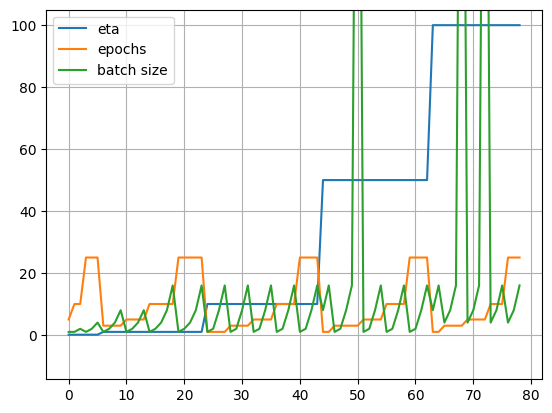

In [62]:
df = pd.DataFrame(optimal_parameters)
display(df.head())
df["eta"] = df["eta"] * 100

plt.plot(df)
plt.ylim(top=105)
plt.grid(True)

plt.legend([
    "eta",
    "epochs",
    "batch size"
])